<a href="https://colab.research.google.com/github/nordic96/OnionOrNot/blob/main/notebook_rnn_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Recursive Neural Network (RNN) - LSTM (Long Short Term Memory) Model for Satir News Headline Classification


This notebook is created to explore the RNN approach for CS4248 Natural Language Processing (NLP) project.

## 1. Checking if GPU is enabled in Google Colab Notebook

In [1]:
!nvidia-smi

Mon Apr 12 05:46:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Necessary Imports for RNN model training
Reference taken from [online](https://jovian.ai/aakanksha-ns/lstm-multiclass-text-classification)

In [2]:
import os
import torch
import nltk
import numpy as np
import string

from collections import Counter
from torchsummary import summary
from matplotlib import pyplot as plt

from tqdm import tqdm_notebook

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.metrics import mean_squared_error

nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

## Mounting with Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dataset Preprocessing

In [4]:
DATA_DIR = 'drive/MyDrive/datasets/'
X = np.load(os.path.join(DATA_DIR, 'merged_dataset_X.npy'))
y = np.load(os.path.join(DATA_DIR, 'merged_dataset_y.npy'))

### Tokenisation & Lemmatization
We now have a dataset of raw text (news headlines) with labels:
1. 0: Not Onion (True News Headline)
1. 1: Onion (Satire News Headline)
1. 2: Fake (Not Onion)

We then process the text data to a list of tokens, and lemmatise any changed form of text

In [5]:
#tokenization & lemmatization
def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    tokenized = word_tokenize(text)
    return [lemmatizer.lemmatize(token) for token in tokenized]

In [6]:
#Checking if tokenisation and vlaidation is working
preprocess_text("Ravioli, Ravioli, what's in the pocketoli")

['Ravioli', ',', 'Ravioli', ',', 'what', "'s", 'in', 'the', 'pocketoli']

### Creating Vocabulary of the dataset

In [9]:
#count number of occurences of each word
counts = Counter()
for sentence in tqdm_notebook(X):
    counts.update(preprocess_text(sentence))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
#deleting infrequent words
print("num_words before:",len(counts.keys()))
for word in list(counts):
    if counts[word] < 2:
        del counts[word]
print("num_words after:",len(counts.keys()))

num_words before: 57326
num_words after: 34364


In [11]:
#creating vocabulary
vocab2index = {"":0, "UNK":1}
words = ["", "UNK"]
for word in tqdm_notebook(counts):
    vocab2index[word] = len(words)
    words.append(word)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [12]:
#Checking max length from the entire news dataset
max(map(lambda x: len(preprocess_text(x)), X))

79

### Encoding the entire dataset with customised vocabulary

In [13]:
def encode_sentence(text, vocab2index, N=79):
    tokenized = preprocess_text(text)
    encoded = np.zeros(N, dtype=int)
    enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
    length = min(N, len(enc1))
    encoded[:length] = enc1[:length]
    return encoded, length

In [14]:
X_encoded = [encode_sentence(x, vocab2index) for x in X]

In [15]:
from torch.utils.data import Dataset

class NewsDataset(Dataset):
    def __init__(self, X, y):
        self.X = np.array(X, dtype=object)
        self.y = np.array(y).astype(np.int)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx][0].astype(np.int32)), self.y[idx], self.X[idx][1]

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.25, random_state=42)
print(len(X_train))
print(len(X_test))

51673
17225


## Defining the Neural Network Model
Now the dataset is prepared, we need to create the RNN model for training. LSTM layer is used.

In [17]:
class LSTM_variable_input(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim) :
        super().__init__()
        self.hidden_dim = hidden_dim
        self.dropout = torch.nn.Dropout(0.3)
        self.embeddings = torch.nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = torch.nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = torch.nn.Linear(hidden_dim, 5)
        
    def forward(self, x, s):
        x = self.embeddings(x)
        x = self.dropout(x)
        x_pack = pack_padded_sequence(x, s, batch_first=True, enforce_sorted=False)
        out_pack, (ht, ct) = self.lstm(x_pack)
        out = self.linear(ht[-1])
        return out

## Training Method

In [18]:
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def train_model(model, epochs=10, lr=0.001):
    train_acc_list = []
    train_loss_list = []
    val_acc_list = []
    val_loss_list = []

    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr)
    for i in range(epochs):
        model.train()
        sum_loss = 0.0
        total = 0
        count = 0
        correct = 0
        for x, y, l in train_dl:
            count += 1
            x = x.long().cuda()
            y = y.long().cuda()
            y_pred = model(x, l)
            optimizer.zero_grad()
            loss = F.cross_entropy(y_pred, y)
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()*y.shape[0]

            _, predicted = torch.max(y_pred, 1)
            correct += (predicted == y).sum().item()
            total += y.shape[0]
            accuracy = 100 * correct / total
            print('[epoch: %5d/%5d, batch: %5d] loss: %.3f, lr: %.10f, acc %d %%'% (i, epochs, count, loss.clone().item(), get_lr(optimizer), accuracy))
        train_acc_list.append(accuracy)
        train_loss_list.append(sum_loss / total)
        
        val_loss, val_acc, val_rmse = validation_metrics(model, val_dl)
        val_acc_list.append(val_acc.cpu() * 100)
        val_loss_list.append(val_loss)
        print("train loss %.3f, val loss %.3f, val accuracy %.3f, and val rmse %.3f" % (sum_loss/total, val_loss, val_acc, val_rmse))
    return train_acc_list, val_acc_list, train_loss_list, val_loss_list

def validation_metrics (model, valid_dl):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    sum_rmse = 0.0
    for x, y, l in valid_dl:
        x = x.long().cuda()
        y = y.long().cuda()
        y_hat = model(x, l)
        loss = F.cross_entropy(y_hat, y)
        pred = torch.max(y_hat, 1)[1]
        correct += (pred == y).float().sum()
        total += y.shape[0]
        sum_loss += loss.item()*y.shape[0]

        mse = mean_squared_error(pred.cpu(), y.unsqueeze(-1).cpu())
        sum_rmse += np.sqrt(mse)*y.shape[0]
    return sum_loss/total, correct/total, sum_rmse/total

## Execution!

In [19]:
train_dataset = NewsDataset(X_train, y_train)
val_dataset = NewsDataset(X_test, y_test)

In [20]:
hidden_dim_size = 79
vocab_size = len(words)
model = LSTM_variable_input(vocab_size=vocab_size, embedding_dim=79, hidden_dim=hidden_dim_size)
model = model.cuda().float()

In [21]:
from torch.utils.data import DataLoader

train_dl = DataLoader(train_dataset, batch_size=128, shuffle=False, num_workers=2, persistent_workers=False)
val_dl = DataLoader(val_dataset, batch_size=128)

In [22]:
IMG_DIR = 'drive/MyDrive/images'
NUM_EPOCH = 30

In [23]:
train_acc_list, val_acc_list, train_loss_list, val_loss_list = train_model(model, epochs=NUM_EPOCH)

Streaming output truncated to the last 5000 lines.
[epoch:    17/   30, batch:   266] loss: 0.044, lr: 0.0010000000, acc 98 %
[epoch:    17/   30, batch:   267] loss: 0.015, lr: 0.0010000000, acc 98 %
[epoch:    17/   30, batch:   268] loss: 0.036, lr: 0.0010000000, acc 98 %
[epoch:    17/   30, batch:   269] loss: 0.025, lr: 0.0010000000, acc 98 %
[epoch:    17/   30, batch:   270] loss: 0.048, lr: 0.0010000000, acc 98 %
[epoch:    17/   30, batch:   271] loss: 0.025, lr: 0.0010000000, acc 98 %
[epoch:    17/   30, batch:   272] loss: 0.035, lr: 0.0010000000, acc 98 %
[epoch:    17/   30, batch:   273] loss: 0.058, lr: 0.0010000000, acc 98 %
[epoch:    17/   30, batch:   274] loss: 0.028, lr: 0.0010000000, acc 98 %
[epoch:    17/   30, batch:   275] loss: 0.035, lr: 0.0010000000, acc 98 %
[epoch:    17/   30, batch:   276] loss: 0.007, lr: 0.0010000000, acc 98 %
[epoch:    17/   30, batch:   277] loss: 0.044, lr: 0.0010000000, acc 98 %
[epoch:    17/   30, batch:   278] loss: 0.014, l

## Evaluation using Accuracy & Loss graph

In [24]:
def plot_train_val_loss_graph(train_loss_list, val_loss_list, feature_name, stop_words=True, save=True):
    x = np.arange(0, NUM_EPOCH)
    plt.plot(x, train_loss_list, label="train loss")

    plt.plot(x, val_loss_list, label="val loss")
    plt.xlabel("epochs")
    plt.ylabel("loss %")
    plt.title(f"Train & Val Loss num {feature_name} Stopwords:{stop_words}")
    plt.legend()

    if save:
        file_name = f'train_val_loss_{feature_name}_stop_{stop_words}.png'
        plt.savefig(os.path.join(IMG_DIR, file_name))
        
    plt.show()

In [25]:
def plot_train_val_acc_graph(train_acc_list, val_acc_list, feature_name, stop_words=True, save=True):
    x = np.arange(0, NUM_EPOCH)
    plt.plot(x, train_acc_list, label="train accuracy")

    plt.plot(x, val_acc_list, label="val accuracy")
    plt.xlabel("epochs")
    plt.ylabel("accuracy %")
    plt.title(f"Train & Val Accuracy num {feature_name} Stopwords:{stop_words}")
    plt.legend()

    if save:
        file_name = f'train_val_acc_{feature_name}_stop_{stop_words}.png'
        plt.savefig(os.path.join(IMG_DIR, file_name))
        
    plt.show()

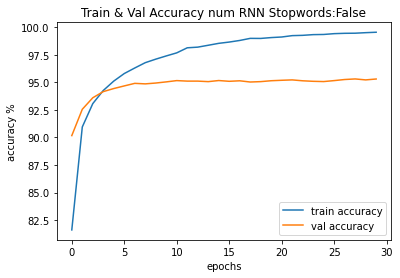

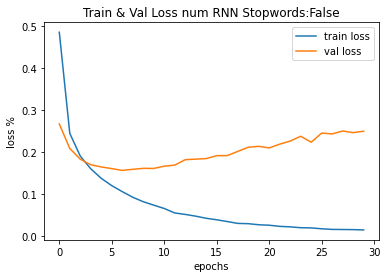

In [28]:
plot_train_val_acc_graph(train_acc_list, val_acc_list, 'RNN', stop_words=False, save=True)
plot_train_val_loss_graph(train_loss_list, val_loss_list, 'RNN', stop_words=False, save=True)

## Testing with Sample news headline from Onion.com

In [29]:
class_map = {
    0: 'not onion (true)',
    1: 'onion',
    2: 'fake'
}

In [30]:
def evaluate_text(text, model):
    encoded_headline = encode_sentence(text, vocab2index)
    encoded_input = np.array([encoded_headline[0]]).astype(np.int32)
    sample_tensor = torch.from_numpy(encoded_input).long().cuda()
    l = encoded_headline[1]

    model.eval()
    y_hat = model(sample_tensor, torch.tensor([l]))
    pred = torch.max(y_hat, 1)[1].cpu().item()
    return class_map[pred]

In [31]:
evaluate_text("Myanmar envoy to London says military seized embassy in 'coup'", model)

'not onion (true)'

In [32]:
evaluate_text("17-Year-Old Asks Friend What It Means When Guy You Like Wants Blanket Pardon", model)

'onion'

In [33]:
evaluate_text("Hillary's alien baby and 7 other out-of-this-world tabloid tales", model)

'not onion (true)'